In [1]:
from math import comb
from itertools import combinations, islice
import time

from Bio import Phylo
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['font.size'] = 12

In [2]:
trees = Phylo.parse('data/n6-1_astral.in', 'newick')
next(trees)
tree = next(trees)

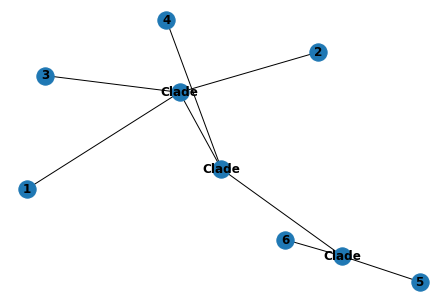

In [3]:
import networkx as nx
G = Phylo.to_networkx(tree)
nx.draw(G, with_labels=True, font_weight='bold')

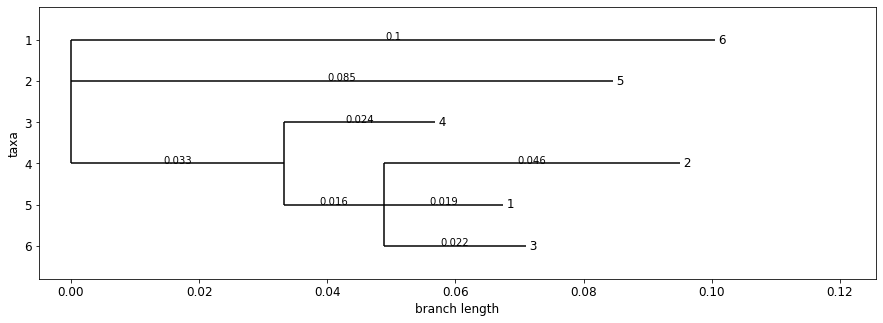

In [4]:
def format_branch_length(node):
    if node.branch_length:
        return f'{node.branch_length:.2}'
    else:
        return ''

fig, ax = plt.subplots(figsize=(15, 5))
Phylo.draw(tree, branch_labels=format_branch_length, axes=ax)

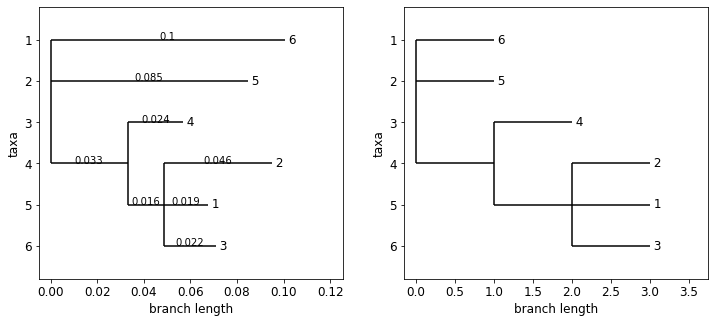

In [5]:
# figures for debugging
def clear_branch_length(clade):
    if clade.clades:
        for c in clade.clades:
            c.branch_length = 1
            clear_branch_length(c)

def draw_equal_branch_length(tree, axes=None):
    t = Phylo.BaseTree.Tree.from_clade(tree.clade)
    clear_branch_length(t.clade)
    Phylo.draw(t, axes=axes)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))
Phylo.draw(tree, axes=ax0, do_show=False, branch_labels=format_branch_length)
draw_equal_branch_length(tree, ax1)

In [6]:
def get_direct_children(clade, res=None):
    '''
    get direct children of each clade
    '''
    if res == None:
        res = {}
    res[clade] = []
    if len(clade.clades) == 0:
        return
    for c in clade.clades:
        res[clade].append(c)
        get_direct_children(c, res)
    return res

def expand_direct_children(res):
    '''
    expand direct children of each clade into descendants
    '''
    res_expand = {}
    for k, v in reversed(res.items()):
        res_expand[k] = []
        for c in v:
            if c.name and str.isdigit(c.name):
                res_expand[k].append(c)
            else:
                res_expand[k].extend(res_expand[c])
    return res_expand

def get_descendants(clade):
    '''
    get descendants of each clade in the `clade`
    '''
    res = get_direct_children(clade)
    return expand_direct_children(res)

def print_children(res):
    def get_name_or_length(c):
        return c.name or (c.branch_length and f'{c.branch_length:.2}')
    for k, v in res.items():
        print(get_name_or_length(k), '\t',
              list(map(lambda c: get_name_or_length(c), v)))
        
def desc_to_length(descendants):
    res = []
    for parent, desc in descendants.items():
        if desc:
            res.append(([d.name for d in desc], parent.branch_length))
        else:
            res.append((parent.name, parent.branch_length))
    return res

In [7]:
children = get_direct_children(tree.clade)
print_children(children)

None 	 ['6', '5', '0.033']
6 	 []
5 	 []
0.033 	 ['4', '0.016']
4 	 []
0.016 	 ['2', '1', '3']
2 	 []
1 	 []
3 	 []


In [8]:
descendants = get_descendants(tree.clade)
print_children(descendants)

3 	 []
1 	 []
2 	 []
0.016 	 ['2', '1', '3']
4 	 []
0.033 	 ['4', '2', '1', '3']
5 	 []
6 	 []
None 	 ['6', '5', '4', '2', '1', '3']


In [9]:
desc_to_length(descendants)

[('3', 0.02224014),
 ('1', 0.01862177),
 ('2', 0.04619028),
 (['2', '1', '3'], 0.01557455),
 ('4', 0.02355061),
 (['4', '2', '1', '3'], 0.03322833),
 ('5', 0.084584),
 ('6', 0.1004835),
 (['6', '5', '4', '2', '1', '3'], None)]

In [10]:
def num_bipartitions(n):
    '''
    summing from nC1 to nC(n-1) and divided by 2
    nC1 is a|bc..n, b|ac..n, n|ab..m
    nC(n-1) is bc..n|a, ac..n|b, ab..m|n
    nC0 and nCn are not possible
    '''
    return sum(comb(n, i) for i in range(1, n)) // 2

def show_bipartitions(n, show_section=False, start=0, end=None):
    idx_width = len(str(num_bipartitions(n)))
    node_width = len(str(n))
    idx = 0
    u = set(range(1, n + 1))
    print('idx\tpartition')
    for i in range(1, n//2+1):
        if show_section:
            print(f'{i}/{n-i}')
            
        iterable = combinations(range(1, n + 1), i)
        if i == n - i:
            iterable = islice(iterable, comb(n, i) // 2)
            
        for l in iterable:
            if start <= idx and (end == None or idx <= end):
                print(f'{idx:{idx_width}}', end='\t')
                for e in l:
                    print(f'{e:{node_width}}', end=' ')
                print('|', end=' ')
                for e in u - set(l):
                    print(f'{e:{node_width}}', end=' ')
                print()
            idx += 1

def show_bipartition(n, idx):
    show_bipartitions(n, start=idx, end=idx)

show_bipartitions(6)
show_bipartition(6, idx=21)

idx	partition
 0	1 | 2 3 4 5 6 
 1	2 | 1 3 4 5 6 
 2	3 | 1 2 4 5 6 
 3	4 | 1 2 3 5 6 
 4	5 | 1 2 3 4 6 
 5	6 | 1 2 3 4 5 
 6	1 2 | 3 4 5 6 
 7	1 3 | 2 4 5 6 
 8	1 4 | 2 3 5 6 
 9	1 5 | 2 3 4 6 
10	1 6 | 2 3 4 5 
11	2 3 | 1 4 5 6 
12	2 4 | 1 3 5 6 
13	2 5 | 1 3 4 6 
14	2 6 | 1 3 4 5 
15	3 4 | 1 2 5 6 
16	3 5 | 1 2 4 6 
17	3 6 | 1 2 4 5 
18	4 5 | 1 2 3 6 
19	4 6 | 1 2 3 5 
20	5 6 | 1 2 3 4 
21	1 2 3 | 4 5 6 
22	1 2 4 | 3 5 6 
23	1 2 5 | 3 4 6 
24	1 2 6 | 3 4 5 
25	1 3 4 | 2 5 6 
26	1 3 5 | 2 4 6 
27	1 3 6 | 2 4 5 
28	1 4 5 | 2 3 6 
29	1 4 6 | 2 3 5 
30	1 5 6 | 2 3 4 
idx	partition
21	1 2 3 | 4 5 6 


In [11]:
class BipartitionEnc():
    def __init__(self, n):
        self.n = n
        self.b = num_bipartitions(n)
        
        self.idx_offset = {}
        self.idx_offset[1] = 0
        for i in range(2, n + 1):
            self.idx_offset[i] = comb(n, i - 1) + self.idx_offset[i - 1]
            
        self.u = set(range(1, n + 1))

    def _rank(self, desc):
        k = len(desc)
        rank = comb(self.n, k)
        for i, d in enumerate(sorted(desc)):
            rank -= comb(self.n - d, k - i)
        return rank

    def get_idx_from_desc(self, desc):
        desc = [int(d) for d in desc]
        if len(desc) > self.n//2:
            desc = self.u - set(desc)
        offset = self.idx_offset[len(desc)]
        rk = self._rank(desc) + offset - 1
        if rk >= self.b:
            rk = 2 * self.b - 1 - rk
        return rk
    
    def encode(self, tree, return_desc=False):
        t_nodes = tree.get_terminals()
        if len(t_nodes) != self.n:
            raise Exception(f'Expected {self.n} terminal nodes, but the tree has {len(t_nodes)}')
        encoding = []
        descendants = get_descendants(tree.clade)
        res = desc_to_length(descendants)
        for desc, branch_length in res:
            if len(desc) != self.n:
                idx = self.get_idx_from_desc(desc)
                if return_desc:
                    encoding.append((desc, idx, branch_length))
                else:
                    encoding.append((idx, branch_length))
        return encoding

In [12]:
be = BipartitionEnc(6)
be.encode(tree)

[(2, 0.02224014),
 (0, 0.01862177),
 (1, 0.04619028),
 (21, 0.01557455),
 (3, 0.02355061),
 (20, 0.03322833),
 (4, 0.084584),
 (5, 0.1004835)]

In [13]:
n = 1000
random_tree = Phylo.BaseTree.Tree.randomized((str(i) for i in range(1, n + 1)))
_ = BipartitionEnc(n).encode(random_tree)

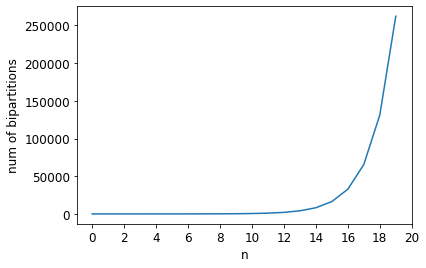

In [14]:
plt.plot([num_bipartitions(i) for i in range(20)])
plt.xticks(range(0, 21, 2))
plt.xlabel('n')
plt.ylabel('num of bipartitions')
plt.show()

In [15]:
# times = []
# for n in range(1, 200):
#     n *= 10
#     random_tree = Phylo.BaseTree.Tree.randomized((str(i) for i in range(1, n + 1)))
#     t0 = time.time()
#     _ = BipartitionEnc(n).encode(random_tree)
#     t1 = time.time()
#     times.append(t1 - t0)
# pd.Series(times).to_csv('be_speed.csv')

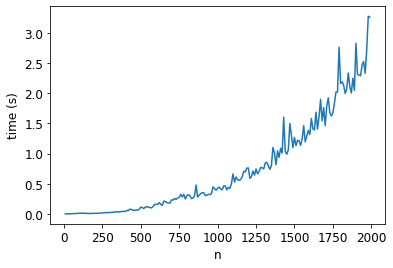

In [16]:
# exponential growth in time complexity
# because exponential growth in bipartition number(?)
times = pd.read_csv('be_speed.csv')
times.index = [i * 10 for i in range(1, 200)]
ax =times.plot(legend=False)
ax.set_xlabel('n')
ax.set_ylabel('time (s)')
plt.show()